### Issue: Overfitting / Shrinkage (L2)

In general, if there are few data points per dimension, noise in the observations induces high variance in the model parameters.

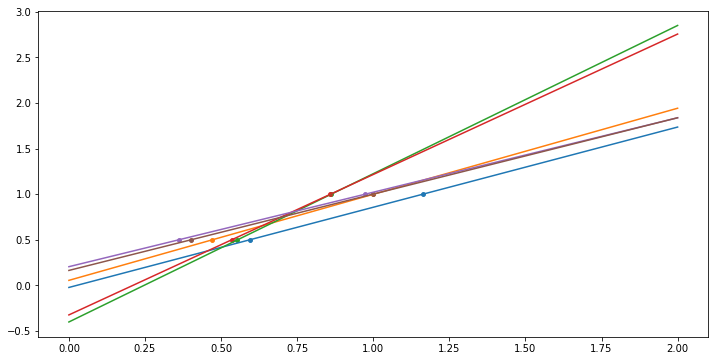

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import linear_model, datasets

X = np.c_[.5, 1].T
y = [.5, 1]
test = np.c_[0, 2].T

regr = linear_model.LinearRegression()
plt.figure(figsize=(12,6))
for _ in range(6):
    this_X = X + .1 * np.random.normal(size=X.shape) # add some noise
    regr.fit(this_X, y)
    plt.plot(test, regr.predict(test))
    plt.scatter(this_X, y, s=15)

One possible solution is to *shrink* the regression coefficients towards zero, since any two randomly chosen set of observations are likely to be uncorrelated. This is called Ridge regression:

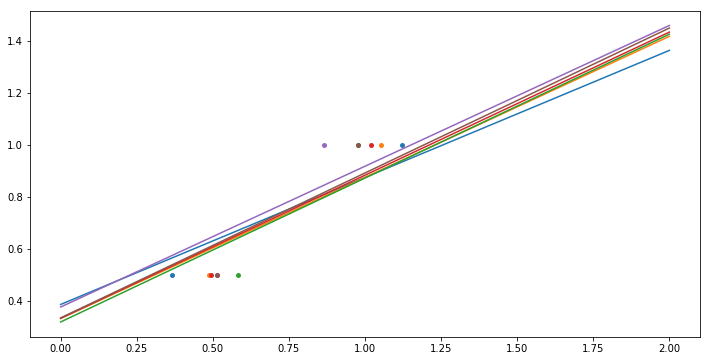

In [2]:
regr = linear_model.Ridge(alpha=0.1) # ad hoc value
plt.figure(figsize=(12,6))
for _ in range(6):
    this_X = X + .1 * np.random.normal(size=X.shape) # add some noise
    regr.fit(this_X, y)
    plt.plot(test, regr.predict(test))
    plt.scatter(this_X, y, s=15)

This is an example of **bias/variance tradeoff**: the larger the ridge alpha parameter, the higher the bias and the lower the variance in the model parameters.

When noise is "captured" in the fitted model parameters, the model is unable to *generalize* to new data. This is also called *overfitting*. The bias introduced by the ridge regression is called *regularization*, and the controlling variable is called the *regularizer*.

We can automatically select the regularizer alpha to minimize the error, this time using the diabetes dataset rather than our synthetic data:

In [3]:
alphas = np.logspace(-4, -1, 6) # search over this range
alphas

array([ 0.0001    ,  0.00039811,  0.00158489,  0.00630957,  0.02511886,
        0.1       ])

In [4]:
diabetes = datasets.load_diabetes()
# input: 10 physiological variables (including age, sex, weight, blood pressure)
# target: an indication of disease progression after one year
X_train = diabetes.data[:-20]
y_train = diabetes.target[:-20]
X_test  = diabetes.data[-20:]
y_test  = diabetes.target[-20:]
scores = np.array([ \
                   regr.set_params(alpha=alpha) \
                   .fit(X_train, y_train) \
                   .score(X_test, y_test) \
                   for alpha in alphas])
scores

array([ 0.58511107,  0.5852073 ,  0.58546775,  0.5855512 ,  0.58307171,
        0.57058999])

In [5]:
alphas[scores.argmax()]

0.0063095734448019303

### Issue: Curse of dimensionality / Sparsity (L1)

For an estimator to be effective, you need the distance between neighboring points to be less than some value $d$, which depends on the problem. In one dimension, this requires on average $n$ $1/d$ points. In the context of the above k-NN example, if the data is described by just one feature with values ranging from 0 to 1 and with $n$ training observations, then new data will be no further away than $1/n$. Therefore, the nearest neighbor decision rule will be efficient as soon as $1/n$ is small compared to the scale of between-class feature variations.

If the number of features is $p$, you now require $n$ $1/d^p$ points. Let’s say that we require 10 points in one dimension: now $10^p$ points are required in $p$ dimensions to pave the [0, 1] space. As $p$ becomes large, the number of training points required for a good estimator grows exponentially.

This is called the curse of dimensionality and is a core problem that machine learning addresses.

To mitigate the curse of dimensionality involing the diabetes dataset, it would be interesting to select only the informative features and set non-informative ones to 0. *Ridge regression* will decrease their contribution, but not set them to zero. Another penalization approach, called *Lasso* (least absolute shrinkage and selection operator), can set some coefficients to zero. Such methods are called sparse methods and sparsity can be seen as an application of Occam’s razor: *prefer simpler models*.

In [6]:
regr = linear_model.Lasso() # or LassoLars
scores = np.array([regr.set_params(alpha=alpha) \
     .fit(X_train, y_train) \
     .score(X_test, y_test) \
     for alpha in alphas])
print(scores)
best_alpha = alphas[scores.argmax()]
print(best_alpha)
regr.alpha = best_alpha
regr.fit(X_train, y_train)
regr.coef_

[ 0.58511911  0.58524714  0.58571895  0.58730095  0.58876224  0.582845  ]
0.0251188643151


array([   0.        , -212.43764548,  517.19478111,  313.77959962,
       -160.8303982 ,   -0.        , -187.19554705,   69.38229038,
        508.66011217,   71.84239008])

Now some coefficients are set to zero, which means that certain features are ignored altogether.

#### Logistic Regression

One can think of classification as regression on a numeric representation of the class labels.

Usually, linear regression is not the right approach as it will give too much weight to data far from the decision frontier. A better approach that is still linear is to fit a sigmoid function or logistic function:

In [7]:
iris = datasets.load_iris()

X = iris.data
y = iris.target
indices = np.random.permutation(len(X))
X_train = X[indices[:-10]]
y_train = y[indices[:-10]]
X_test  = X[indices[-10:]]
y_test  = y[indices[-10:]]

In [8]:
logistic = linear_model.LogisticRegression(C=1e5, penalty='l2')  # l1 gives sparsity, l2 gives shrinkage
logistic.fit(X_train, y_train)
print(logistic.score(X_test, y_test))
logistic.coef_

0.8


array([[  1.52313753,   4.86952365,  -7.77758258,  -3.81078747],
       [ -0.76335705,  -2.67567642,   1.90835914,  -3.65335291],
       [ -1.17729788,  -6.25928414,   7.86832435,  18.46842929]])